In [32]:
import torch
import torch.nn as nn 
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

In [24]:
class DigitDataset():
    def __init__(
        self, data_path: Path, transformse: bool = False
    ) -> None:
        super().__init__()
        self.dataset = pd.read_csv(data_path)
        self.transforms = transforms.ToTensor()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data = self.dataset.iloc[index]
        label, data = data[0], data[1:]
        data = np.reshape(np.array(data, dtype=np.uint8), (28,28))
        data = self.transforms(data) # Transform values to be in range 0-1

        return data, label

In [25]:
def data_viz(data, label, tile: bool = False):
    if tile:
        num_samples = data.shape[0]
        plt_row = int(np.sqrt(num_samples))
        plt_col = int(np.ceil(num_samples / plt_row))
        for i in range(num_samples):
            img = data[i].squeeze()
            plt.subplot(plt_row, plt_col, i + 1)
            plt.title("Label: " + str(int(label[i])))
            plt.axis("off")
            plt.imshow(img)
        plt.tight_layout()
    else:
        img = data.squeeze()
        plt.title("Label: " + str(int(label)))
        plt.axis("off")
        plt.imshow(img)
    plt.show()

In [26]:
train_path = Path("./Dataset/train.csv")
train_dataset = DigitDataset(data_path=train_path)
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=False)

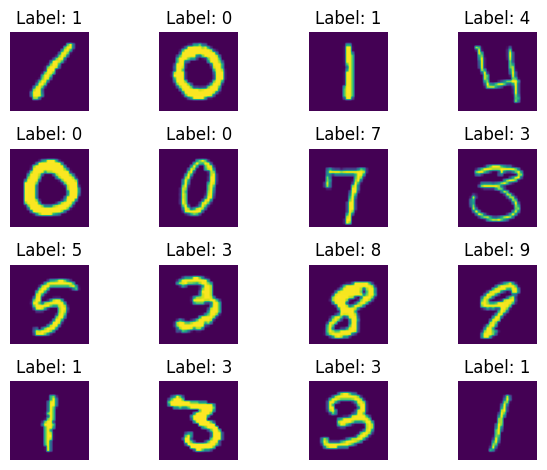

[INFO] Minimum data value: 0.0, Maximum data value: 1.0


In [27]:
images, labels = next(iter(train_loader))
data_viz(data=images, label=labels, tile=True)
print(f"[INFO] Minimum data value: {torch.min(images)}, Maximum data value: {torch.max(images)}")

In [28]:
class Autoencoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # N, 1, 28, 28
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1), # N, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1), # N, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7), # N, 64, 1, 1
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=7), # N, 32, 7, 7
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1), # N, 16, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1), # N, 1, 28, 28
            nn.Sigmoid(), 
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Note: Data min,max [-1, 1] -> Tanh activation function
# nn.MaxPool2d -> nn.MaxUnpool2d

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Current running device: {device}")

[INFO] Current running device: cuda


In [31]:
model = Autoencoder()
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

In [35]:
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [36]:
import time
current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime(time.time()))
writer = SummaryWriter(log_dir=f"train_output/{current_time}")

ModuleNotFoundError: No module named 'datatime'

In [ ]:
num_epochs = 30
outputs = []

train_loss =0.
for epoch in tqdm(range(num_epochs)):
    for (img, _) in train_loader:
        img = img.to(device)
        recon = model(img)
        loss = criterion(recon, img)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_loader)
    writer.add_scalar("Train Loss [epoch]", train_loss, epoch)
    print(f"[INFO] Epoch: {epoch+1}, Loss: {loss.item():.4f}")
    outputs.append((epoch, img, recon))